In [1]:
#Classification of MNIST dataset 
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using MLDatasets
using IterTools #Only for plots, not for program

using StatsPlots
using Measures

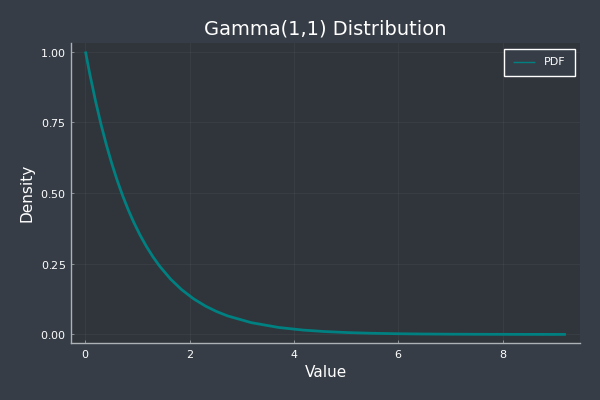

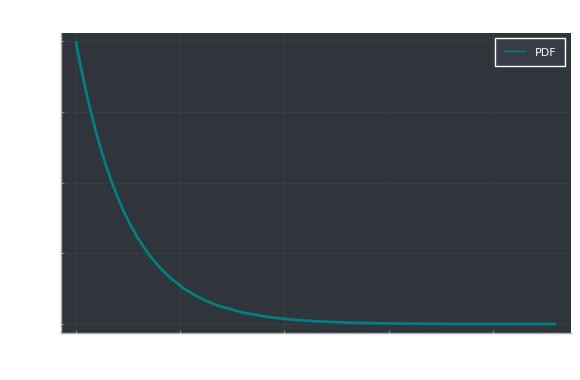

In [2]:
theme(:dark)
pyplot()

num = 100000
x_axis = [1:num]
y_axis = rand(Gamma(1,1),num)

plt = plot(Gamma(1,1),
    xlabel="Value",
    ylabel="Density",
    title="Gamma(1,1) Distribution",
    label="PDF",
    linewidth=2,
    color=:teal,
    bottom_margin=5mm,
    top_margin=5mm,
    left_margin=5mm,
    right_margin=5mm)
display(plt)

#plt.plot_title("10000 Draws from Gamma(1,1) Distribution")
#plt.xlabel("Value")
#plt.ylabel("Count");

2×2 Array{Float64,2}:
 1.0  0.9
 0.9  1.0

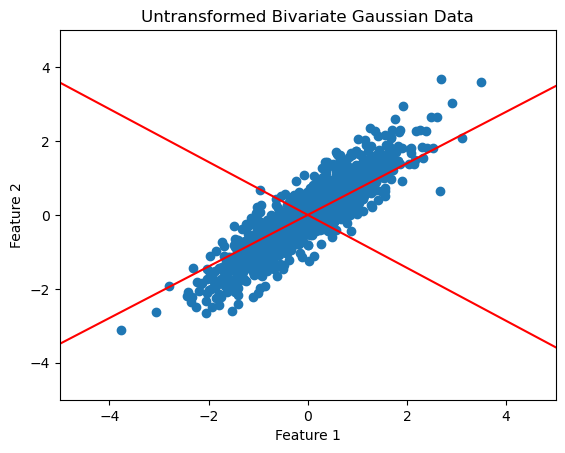

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fea81ae69d0>

In [141]:
using PyPlot
μ = [0,0]
Σ = [1 0.9
    0.9 1.0]
display(Σ)
x = rand(MvNormal(μ,Σ),1000)
PyPlot.scatter(x[1,:],x[2,:])
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("Untransformed Bivariate Gaussian Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

dims = 2
x_pca = fit(PCA,x,maxoutdim=dims)
xt = transform(x_pca,x)

x2 = x*transpose(x)
A = eigvecs(x2)
xs = [-5+i/1000 for i=1:10000]
line1 = [A[1,1]*i for i in xs]
line2 = [A[2,1]*i for i in xs]
PyPlot.plot(xs,line1,color="red")
PyPlot.plot(xs,line2,color="red")

In [47]:
dims = 2
x_pca = fit(PCA,x,maxoutdim=dims)
xt = transform(x_pca,x)

x_pca.prinvars

2-element Array{Float64,1}:
 1.7091884865501215
 0.2056938760535491

In [123]:
cov(x2)

2×2 Array{Float64,2}:
  1.44232e6  -1.93638e6
 -1.93638e6   2.59967e6

In [119]:
x2 = x*transpose(x)
A = eigvecs(x2)
e1 = A[1,2]/A[1,1]
e2 = A[2,2]/A[2,1]

1.0011323032821284

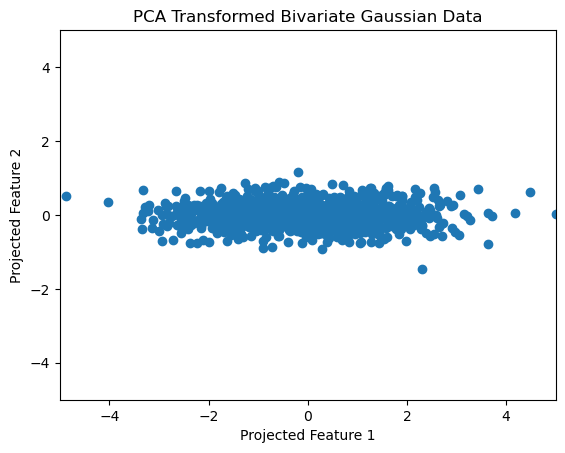

PyObject Text(24.000000000000007, 0.5, 'Projected Feature 2')

In [142]:
PyPlot.scatter(xt[1,:],xt[2,:])
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("PCA Transformed Bivariate Gaussian Data")
plt.xlabel("Projected Feature 1")
plt.ylabel("Projected Feature 2")